<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.font_manager import FontProperties

In [2]:
# Loading datasets
data = pd.read_csv('data/varying_LR_data.csv', names = ['tech', 'form', 'a', 'b','c','d','m'], header=0)
hist_cost_data = pd.read_csv('data/Historical_data_summary.csv', names = ['tech', 'year', 'c_inv','installed_cap'], header=0)
hist_cost_electrolysis = pd.read_csv('data/Historical_electrolysis.csv', names = ['tech', 'year', 'c_inv','installed_cap','annual_prod'], header=0)
hist_cost_carbon_capture = pd.read_csv('data/Historical_carbon_capture.csv', names = ['tech', 'year', 'c_inv','installed_cap'], header=0)
hist_cost_gshp = pd.read_csv('data/Historical_gshp.csv', names = ['tech', 'year', 'c_inv','installed_cap'], header=0)
future_cost_data = pd.read_csv('data/Cost_data_summary_V2.csv', names = ['tech', 'year', 'cost_ratio', 'c_inv','installed_cap','annual_prod'], header=0)

In [3]:
plt.rcParams.update({'font.size': 21})
plt.rcParams["figure.figsize"] = (6,5)
plt.tight_layout()

<Figure size 432x360 with 0 Axes>

In [4]:
def boone(x,a,b,c):
    return(a*x**(b/(1+x/c)))

In [5]:
def sigmoid(x,a,b,c,d):
    return a/(b+np.exp(-c*x))+d

In [6]:
def plateau(x,a,b,c):
    return a+c*x**b

In [7]:
def s_curve(x,c,m,a,b):
    return c*(m+(1-m)*(x+a)**b)

In [8]:
def wright(x,a,b):
    return np.exp(a+b*np.log(x))

In [9]:
# colours 

colour_main_axis = "rgb(10,10,10)"
colour_second_axis = "rgb(10,10,10)"
colour_carbon_capture = "rgb(105,105,105)"

# Blue
colour_onshore_wind = 'rgb(0,0,205)'
colour_offshore_wind = 'rgb(30,144,255)'
colour_hydro = 'rgb(25,25,112)'

# Yellow/orange
colour_res_pv = 'rgb(255,220,0)'
colour_uti_pv = 'rgb(255,180,0)'
colour_com_pv = 'rgb(255,140,0)'
colour_csp_solar = 'rgb(218,165,32)'

# other
colour_gshp = 'rgb(50,205,50)'
colour_ashp = 'rgb(0,128,128)'
colour_geoth = 'rgb(0,100,0)'
colour_soec = 'rgb(139,0,139)'
colour_alk = 'rgb(210,105,30)'
colour_pem = 'rgb(178,34,34)'

In [10]:
list(future_cost_data.tech.unique())

['RES_PV',
 'ONSHORE_WIND',
 'WOOD_GASIFICATION',
 'SOEC_ELECTROLYSIS',
 'PEM_ELECTROLYSIS',
 'ALKALINE_ELECTROLYSIS',
 'DEC_HP_ELEC',
 'CARBON_CAPTURE',
 'CARBON_SEQUSTRATION',
 'DEC_SOLAR',
 'HYDRO_TOTAL',
 'DHN_HP_ELEC',
 'OFFSHORE_WIND',
 'UTILITY_PV',
 'COMMERCIAL_PV',
 'GEOTHERMAL']

By definition, the learning rate is the cost reduction coefficient when the capacity is doubled. 
In this plot, we compute "manually" the LR's year-by-year i.e. there is no explicit formula of LR for most of the function we use, so we double the capacity, compute the theoritical cost and then make the ratio in order to get the LR. 

In [11]:
future_cost_data.head()

,tech,year,cost_ratio,c_inv,installed_cap,annual_prod
0,RES_PV,2018,1.000,2704.85,58.00,NaN
1,RES_PV,2019,0.927,2506.80,74.00,NaN
2,RES_PV,2020,0.903,2442.72,93.00,NaN
3,RES_PV,2021,0.692,1872.68,150.67,NaN
4,RES_PV,2022,0.606,1639.53,208.35,NaN


In [12]:
data.head()

,tech,form,a,b,c,d,m
0,ONSHORE_WIND,Wright,8.796934,-0.233720,NaN,NaN,NaN
1,ONSHORE_WIND,S-curve,925.046000,-0.952119,1.541860e+06,NaN,0.00001
2,ONSHORE_WIND,Plateau,-93790.000000,-0.004648,9.812630e+04,NaN,NaN
3,ONSHORE_WIND,Boone,318.855000,0.433299,7.105880e+02,NaN,NaN
4,ONSHORE_WIND,Sigmoid,-402.948000,0.248604,3.068020e-03,2424.74,NaN


In [13]:
def LR(tech): # returns the year-by-year LR between 2018 and 2050 for the given technology
    
    # Future cap and costs
    future_data = future_cost_data[future_cost_data.tech == tech]
    
    dat = data[data.tech == tech]
    
    # Wright's form parameters
    wright_a = float(dat[dat.form == 'Wright'].a)
    wright_b = float(dat[dat.form == 'Wright'].b)
    
    # Boone's form parameters
    boone_a = float(dat[dat.form == 'Boone'].a)
    boone_b = float(dat[dat.form == 'Boone'].b)
    boone_c = float(dat[dat.form == 'Boone'].c)
    
    # Sigmoid's form parameters 
    sigmoid_a = float(dat[dat.form == 'Sigmoid'].a)
    sigmoid_b = float(dat[dat.form == 'Sigmoid'].b)
    sigmoid_c = float(dat[dat.form == 'Sigmoid'].c)
    sigmoid_d = float(dat[dat.form == 'Sigmoid'].d)
    
    # Sigmoid's form parameters 
    plateau_a = float(dat[dat.form == 'Plateau'].a)
    plateau_b = float(dat[dat.form == 'Plateau'].b)
    plateau_c = float(dat[dat.form == 'Plateau'].c)
    
    # S-curve's form parameters 
    scurve_a = float(dat[dat.form == 'S-curve'].a)
    scurve_b = float(dat[dat.form == 'S-curve'].b)
    scurve_c = float(dat[dat.form == 'S-curve'].c)
    scurve_m = float(dat[dat.form == 'S-curve'].m)
    
    list_LR_wright = []
    list_LR_boone = []
    list_LR_sigmoid = []
    list_LR_plateau = []
    list_LR_scurve = []
    
    for year in range(2018,2051):
        cap = future_data[future_data.year == year].installed_cap
        
        LR_wright = 100*(1-float(wright(x=2*cap,a=wright_a,b=wright_b)/wright(x=cap,a=wright_a,b=wright_b)))
        LR_boone = 100*(1-float(boone(x=2*cap,a=boone_a,b=boone_b,c=boone_c)/boone(x=cap,a=boone_a,b=boone_b,c=boone_c)))
        LR_sigmoid = 100*(1-float(sigmoid(x=2*cap,a=sigmoid_a,b=sigmoid_b,c=sigmoid_c,d=sigmoid_d)/sigmoid(x=cap,a=sigmoid_a,b=sigmoid_b,c=sigmoid_c,d=sigmoid_d)))
        LR_scurve = 100*(1-float(s_curve(x=2*cap,a=scurve_a,b=scurve_b,c=scurve_c,m=scurve_m)/s_curve(x=cap,a=scurve_a,b=scurve_b,c=scurve_c,m=scurve_m)))
        LR_plateau = 100*(1-float(plateau(x=2*cap,a=plateau_a,b=plateau_b,c=plateau_c)/plateau(x=cap,a=plateau_a,b=plateau_b,c=plateau_c)))
        
        list_LR_wright.append(LR_wright)
        list_LR_boone.append(LR_boone)
        list_LR_sigmoid.append(LR_sigmoid)
        list_LR_scurve.append(LR_scurve)
        list_LR_plateau.append(LR_plateau)
    
    return(list_LR_wright, list_LR_boone, list_LR_sigmoid, list_LR_plateau, list_LR_scurve)

In [14]:
def LR_carbon_capture(): # returns the year-by-year LR between 2018 and 2050 for the given technology
    
    # Future cap and costs
    future_data = future_cost_data[future_cost_data.tech == "CARBON_CAPTURE"]
    
    dat = data[data.tech == "CARBON_CAPTURE"]
    
    # Wright's form parameters
    wright_a = float(dat[dat.form == 'Wright'].a)
    wright_b = float(dat[dat.form == 'Wright'].b)
    
    # Boone's form parameters
    boone_a = float(dat[dat.form == 'Boone'].a)
    boone_b = float(dat[dat.form == 'Boone'].b)
    boone_c = float(dat[dat.form == 'Boone'].c)
    
    # Sigmoid's form parameters 
    sigmoid_a = float(dat[dat.form == 'Sigmoid'].a)
    sigmoid_b = float(dat[dat.form == 'Sigmoid'].b)
    sigmoid_c = float(dat[dat.form == 'Sigmoid'].c)
    sigmoid_d = float(dat[dat.form == 'Sigmoid'].d)
    
    # Sigmoid's form parameters 
    plateau_a = float(dat[dat.form == 'Plateau'].a)
    plateau_b = float(dat[dat.form == 'Plateau'].b)
    plateau_c = float(dat[dat.form == 'Plateau'].c)
    
    # S-curve's form parameters 
    scurve_a = float(dat[dat.form == 'S-curve'].a)
    scurve_b = float(dat[dat.form == 'S-curve'].b)
    scurve_c = float(dat[dat.form == 'S-curve'].c)
    scurve_m = float(dat[dat.form == 'S-curve'].m)
    
    list_LR_wright = []
    list_LR_boone = []
    list_LR_sigmoid = []
    list_LR_plateau = []
    list_LR_scurve = []
    
    for year in range(2018,2051):
        cap = future_data[future_data.year == year].installed_cap/1000
        
        LR_wright = 100*(1-float(wright(x=2*cap,a=wright_a,b=wright_b)/wright(x=cap,a=wright_a,b=wright_b)))
        LR_boone = 100*(1-float(boone(x=2*cap,a=boone_a,b=boone_b,c=boone_c)/boone(x=cap,a=boone_a,b=boone_b,c=boone_c)))
        LR_sigmoid = 100*(1-float(sigmoid(x=2*cap,a=sigmoid_a,b=sigmoid_b,c=sigmoid_c,d=sigmoid_d)/sigmoid(x=cap,a=sigmoid_a,b=sigmoid_b,c=sigmoid_c,d=sigmoid_d)))
        LR_scurve = 100*(1-float(s_curve(x=2*cap,a=scurve_a,b=scurve_b,c=scurve_c,m=scurve_m)/s_curve(x=cap,a=scurve_a,b=scurve_b,c=scurve_c,m=scurve_m)))
        LR_plateau = 100*(1-float(plateau(x=2*cap,a=plateau_a,b=plateau_b,c=plateau_c)/plateau(x=cap,a=plateau_a,b=plateau_b,c=plateau_c)))
        
        list_LR_wright.append(LR_wright)
        list_LR_boone.append(LR_boone)
        list_LR_sigmoid.append(LR_sigmoid)
        list_LR_scurve.append(LR_scurve)
        list_LR_plateau.append(LR_plateau)
    
    return(list_LR_wright, list_LR_boone, list_LR_sigmoid, list_LR_plateau, list_LR_scurve)

In [15]:
def plot(tech):
    
    LR_wright = LR(tech)[0]
    LR_boone = LR(tech)[1]
    LR_sigmoid = LR(tech)[2]
    LR_plateau = LR(tech)[3]
    LR_scurve = LR(tech)[4]
    
    year = range(2018,2051)
    
    # Plot's paramters 
    #plt.figure(figsize=(8, 6), dpi=80)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.xlabel("Year")
    plt.ylabel("Learning rate [%]")
    
    # Curves 
    plt.plot(year,LR_wright,'r-',label='Wright')
    plt.plot(year,LR_boone,'g-',label='Boone')
    plt.plot(year,LR_sigmoid,'b-',label='Sigmoid')
    plt.plot(year,LR_plateau,'m-',label='Plateau')
    plt.plot(year,LR_scurve,'c-',label='S-curve')
    plt.legend(fontsize=17)
    
    plt.savefig('pics/LR_'+tech+'.pdf')
    
    plt.show()

In [17]:
def plot_carbon_capture():
    
    LR_wright = LR_carbon_capture()[0]
    LR_boone = LR_carbon_capture()[1]
    LR_sigmoid = LR_carbon_capture()[2]
    LR_plateau = LR_carbon_capture()[3]
    LR_scurve = LR_carbon_capture()[4]
    
    year = range(2018,2051)
    
    # Plot's paramters 
    #plt.figure(figsize=(8, 6), dpi=80)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.xlabel("Year")
    plt.ylabel("Learning rate [%]")
    
    # Curves 
    plt.plot(year,LR_wright,'r-',label='Wright')
    plt.plot(year,LR_boone,'g-',label='Boone')
    plt.plot(year,LR_sigmoid,'b-',label='Sigmoid')
    plt.plot(year,LR_plateau,'m-',label='Plateau')
    plt.plot(year,LR_scurve,'c-',label='S-curve')
    plt.legend(fontsize=17)
    
    plt.savefig('pics/LR_'+"CARBON_CAPTURE"+'.pdf')
    
    plt.show()

In [17]:
list(data.tech.unique())

['ONSHORE_WIND',
 'OFFSHORE_WIND',
 'RES_PV',
 'UTILITY_PV',
 'COMMERCIAL_PV',
 'DEC_SOLAR',
 'ALKALINE_ELECTROLYSIS',
 'PEM_ELECTROLYSIS',
 'SOEC_ELECTROLYSIS',
 'DHN_HP_ELEC',
 'GEOTHERMAL',
 'CARBON_CAPTURE',
 'HYDRO_TOTAL']

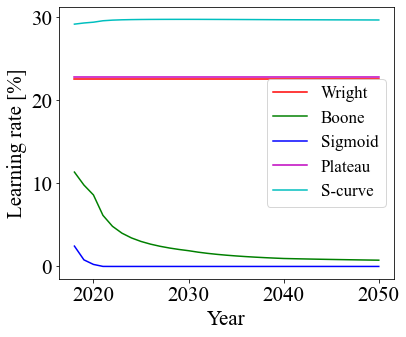

In [16]:
plot("UTILITY_PV")

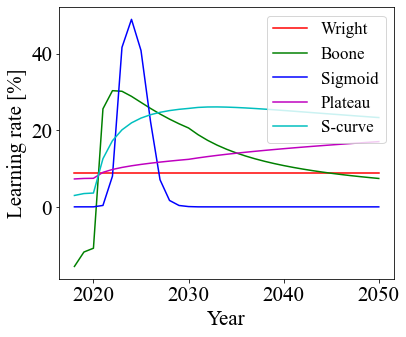

In [19]:
plot_carbon_capture()

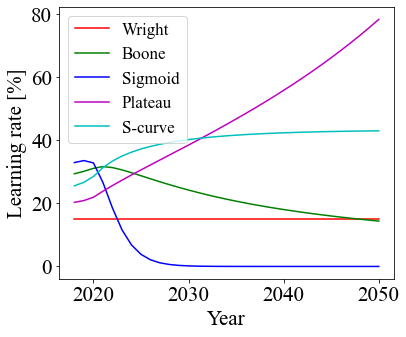

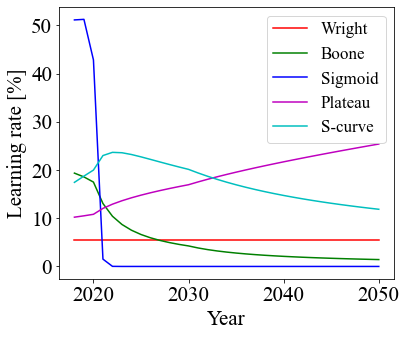

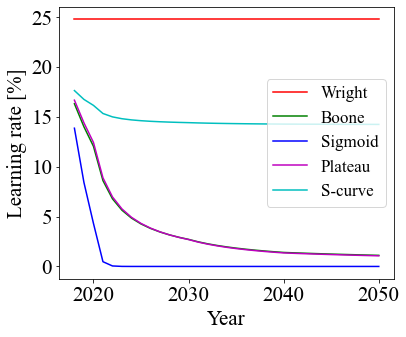

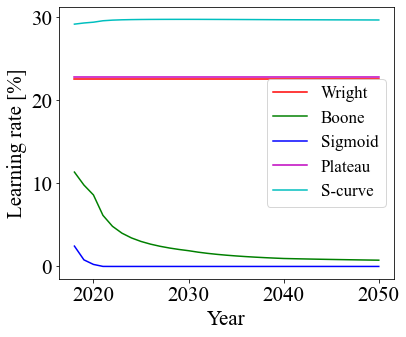

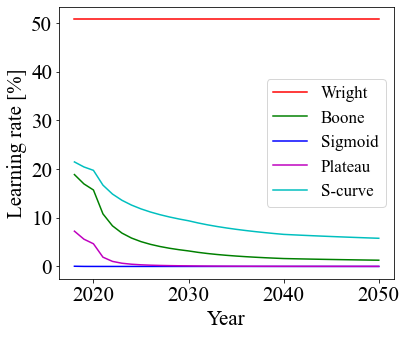

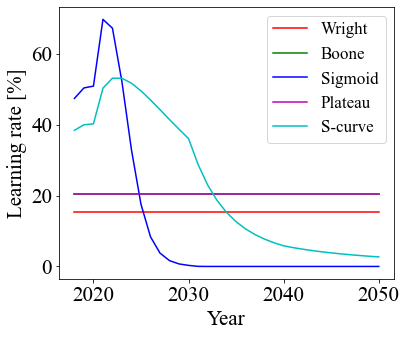

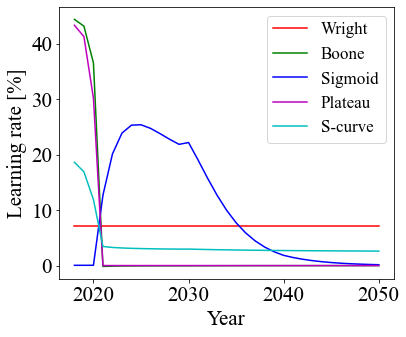

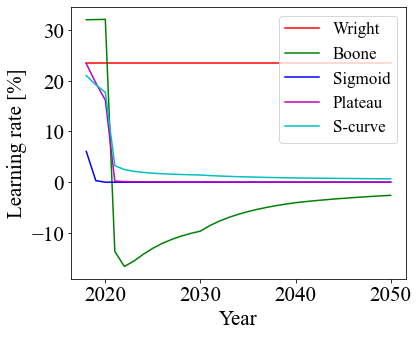

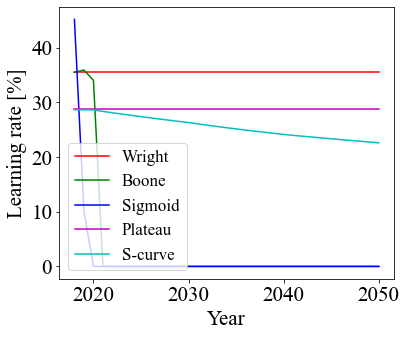

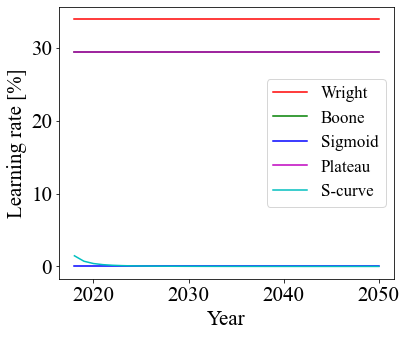

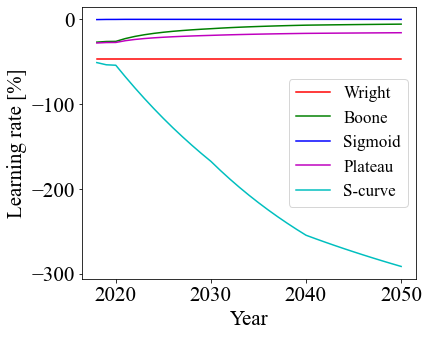

C:\Users\QQ6354\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


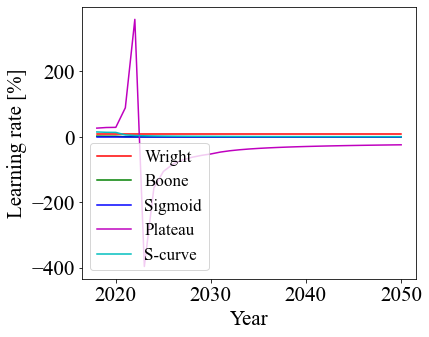

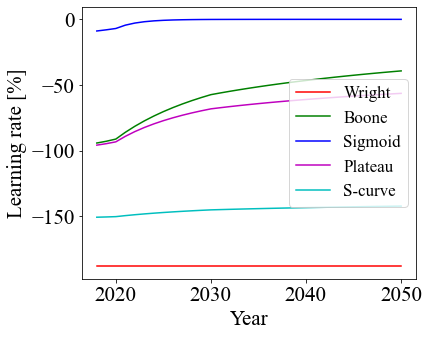

In [18]:
for tech in list(data.tech.unique()):
    plot(tech)

In [30]:
def LR_min_max(tech):
    
    LR_wright = LR(tech)[0]
    LR_boone = LR(tech)[1]
    LR_sigmoid = LR(tech)[2]
    LR_plateau = LR(tech)[3]
    LR_scurve = LR(tech)[4]
    
    LR_wright_min = min(LR(tech)[0])
    LR_wright_max = max(LR(tech)[0])
    
    print("Wright:",round(LR_wright_min,2), round(LR_wright_max,2))
    
    LR_boone_min = min(LR(tech)[1])
    LR_boone_max = max(LR(tech)[1])
    
    print("boone:",round(LR_boone_min,2), round(LR_boone_max,2))
    
    LR_sigmoid_min = min(LR(tech)[2])
    LR_sigmoid_max = max(LR(tech)[2])
    
    print("sigmoid:",round(LR_sigmoid_min,2), round(LR_sigmoid_max,2))
    
    LR_plateau_min = min(LR(tech)[3])
    LR_plateau_max = max(LR(tech)[3])
    
    print("plateau:",round(LR_plateau_min,2), round(LR_plateau_max,2))
    
    LR_scurve_min = min(LR(tech)[4])
    LR_scurve_max = max(LR(tech)[4])
    
    print("s-curve:",round(LR_scurve_min,2), round(LR_scurve_max,2))

In [41]:
LR_min_max("HYDRO_TOTAL")

Wright: -188.28 -188.28
boone: -94.22 -39.28
sigmoid: -8.86 -0.0
plateau: -95.85 -56.39
s-curve: -150.77 -142.3


In [44]:
round(min(LR_carbon_capture()[3]),2), round(max(LR_carbon_capture()[3]),2)

(7.29, 17.04)